# Tune changepoint detection algorithm

### Что сделали в этом ноутбуке:
0. Взяли данные для income и outcome

1. Разметили оба ряда на разладки

2. Взяли KLIEP (Kullback-Leibler importance estimation procedure) алгоритм для детекции разладки   
[S. Liu, M. Yamada, N. Collier, and M. Sugiyama, “Change-point detection in time-series data by relative density-ratio estimation,” Neural Networks, vol. 43, pp. 72–83, 2013.]

3. Подобрали гиперпараметры и протестировали

In [1]:
import numpy as np
from numpy.random import randn
from numpy.random import laplace
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from pathlib import Path 

import sys
import os
sys.path.insert(1, str(Path(os.getcwd()).resolve().parent))

from project.kliep import compute_test_stat_kliep, train_kliep, perform_kliep

%matplotlib inline

In [2]:
%reload_ext autoreload
%autoreload 2

## Auxiliary functions

In [3]:
def plot_data_with_cp(df, column_name, interval=[0,-1], changepoints=None):
    title = f"{column_name} "
    
    fig, axes = plt.subplots(1, 1, squeeze=False)

    # x = df.index
    x = range(len(df))
    y = df[column_name]

    if interval != [0,-1]:
        x = x[interval[0]: interval[1]]
        y = y[interval[0]: interval[1]]

        if not changepoints is None:
            changepoints = changepoints[(changepoints >= interval[0]) & (changepoints <= interval[1])]

    plt.plot(x, y, color="#000066")

    if not changepoints is None:
            plt.vlines(x=changepoints, ymin=y.min(), ymax=y.max(), colors='#ff00bf', ls=':', lw=1.5)

    fig.suptitle(title)

In [4]:
def change_series(df, date_column, series_column, type_change=None):
    if type_change is None:
        return df
    
    cols = [series_column]
    new_df = pd.DataFrame(columns=[date_column].extend(cols))
    new_df[date_column] = df[date_column][:-1]
    for c in cols:
        if type_change == 'log_simple':
            new_df[c] = (np.log1p(np.roll(df[c], -1)) - np.log1p(df[c]))[:-1]
        elif type_change == 'lin':
            new_df[c] = (np.roll(df[c], -1) - df[c])[:-1]
        else:
            new_df[c] = np.log1p(abs(np.roll(df[c], -1) -df[c]) / abs(df[c] + 1))[:-1]

    return new_df

## Income

In [5]:
data = pd.read_csv('../datasets/balances.csv')
data.head(3)

,date,income,outcome,balance
0,2017-01-09,1.343028,1.487865,-0.155904
1,2017-01-10,1.068610,1.194182,-0.125572
2,2017-01-11,0.944429,0.936663,0.007767


In [6]:
series_column = 'income'

In [7]:
change_points = np.array([
    550,
    750,
    850,
    1050,
    1150,
    1200,
    ])

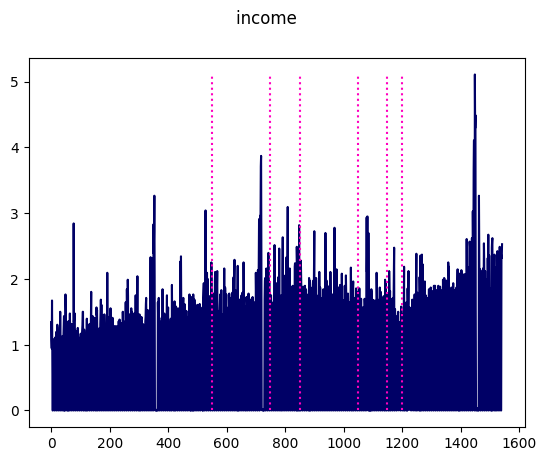

In [8]:
plot_data_with_cp(data, series_column, changepoints=change_points)

In [10]:
data_changed = change_series(data, date_column='date', series_column=series_column, type_change="lin")

In [16]:
data_val = data_changed[series_column].values

max_stationary_point = 550
data_stationary = [data_val[:max_stationary_point]]

### KLIEP

In [15]:
verbose = False
min_diff = 10
WINDOW_SIZE = 50

# The list of hyperparameters
sigma_list = [0.01, 0.025, 0.03, 0.05]

print('Validation change points:', change_points)
    
    
for sigma in sigma_list:
    
    #----------------------------------------------------
    # Step 1: tuning the threshold on the stationary part
    #----------------------------------------------------
    
    S_stationary = np.empty(0)
    for ds in data_stationary:
        
        S, _ = compute_test_stat_kliep(ds, window_size=WINDOW_SIZE, sigma=sigma)
        S_stationary = np.append(S_stationary, S)
        
    # Set the threshold as the maximal value on the stationary part
    z = np.max(S_stationary)
    zs = np.linspace(z-10, z+1, 10)
    print(zs)
    #----------------------------------------------------
    # Step 2: detect changes on the validation part
    #----------------------------------------------------
    for z in zs:
        # Initialization of the test statistic
        train_kliep(data_val, sigma, z, min_diff, WINDOW_SIZE, change_points, verbose=False)

Validation change points: [ 550  750  850 1050 1150 1200]
[122.2086197  123.43084192 124.65306414 125.87528636 127.09750858
 128.31973081 129.54195303 130.76417525 131.98639747 133.2086197 ]
KLIEP, sigma = 0.01 . Number of false alarms: 2 ; average delay: 38.333333333333336 ± 39.798101573930495
KLIEP, sigma = 0.01 . Number of false alarms: 2 ; average delay: 39.333333333333336 ± 39.04128868547018
KLIEP, sigma = 0.01 . Number of false alarms: 1 ; average delay: 41.833333333333336 ± 37.84361093882148
KLIEP, sigma = 0.01 . Number of false alarms: 1 ; average delay: 88.33333333333333 ± 60.79930555158962
KLIEP, sigma = 0.01 . Number of false alarms: 1 ; average delay: 89.0 ± 60.94806532341011
KLIEP, sigma = 0.01 . Number of false alarms: 2 ; average delay: 101.5 ± 75.4624630749178
KLIEP, sigma = 0.01 . Number of false alarms: 2 ; average delay: 102.5 ± 74.93052337554658
KLIEP, sigma = 0.01 . Number of false alarms: 2 ; average delay: 102.5 ± 74.93052337554658
KLIEP, sigma = 0.01 . Number of

In [18]:
#TRAIN
sigma = 0.03
z = 76
min_diff = 10
WINDOW_SIZE=50
verbose=True


stat, delays = train_kliep(data_val, sigma, z, min_diff, WINDOW_SIZE, change_points, verbose=True)

Detected change point: 282
False Alarm
Detected change point: 567
Detected change point: 743
Detected change point: 844
Detected change point: 1094
Detected change point: 1249
Detected change point: 1453
False Alarm
KLIEP, threshold = 76 . sigma = 0.03 . Number of false alarms: 2 ; average delay: 26.666666666666668 ± 21.83015244004392


In [30]:
stat, change_points_kliep = perform_kliep(data_val, sigma, z, WINDOW_SIZE, verbose=True)

Detected change point: 282
Detected change point: 567
Detected change point: 743
Detected change point: 844
Detected change point: 1094
Detected change point: 1249
Detected change point: 1453


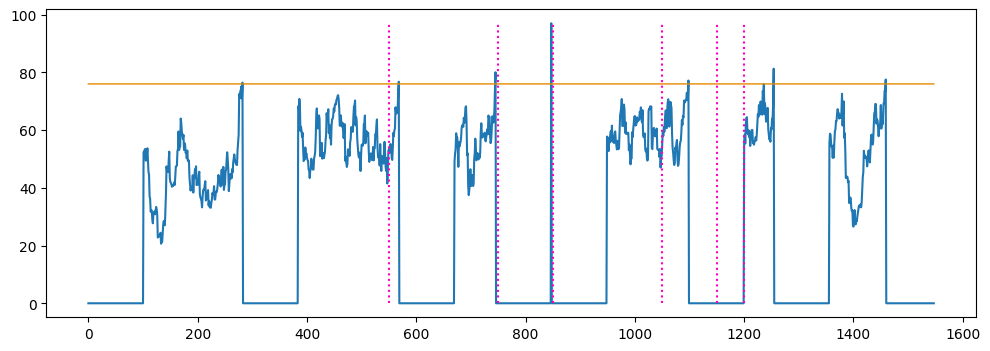

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(stat)
plt.vlines(x=change_points,  ymin=stat.min(), ymax=stat.max(), colors='#ff00bf', ls=':', lw=1.5)
plt.plot([z] * stat.shape[0], color="#e68a00", lw=1)
plt.show()

## Outcome

In [40]:
data = pd.read_csv('TS_project/datasets/balances.csv')
data.head(3)

series_column = 'outcome'

In [111]:
change_points = np.array([
    210,
    350,
    640,
    900,
    970,
    1200,
    1300,
    1450,
    ])

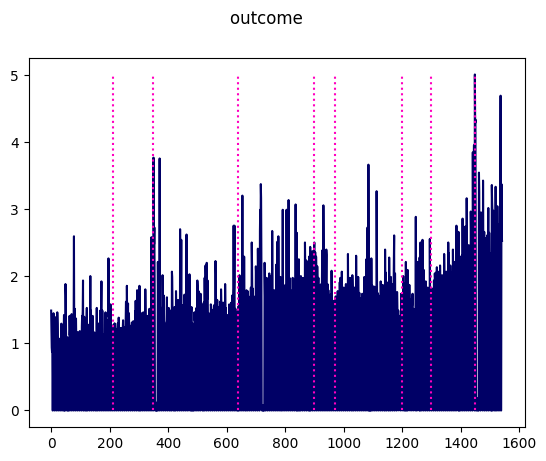

In [112]:
plot_data_with_cp(data, series_column, changepoints=change_points)

In [95]:
data_changed = change_series(data, date_column='date', series_column=series_column, type_change="lin")

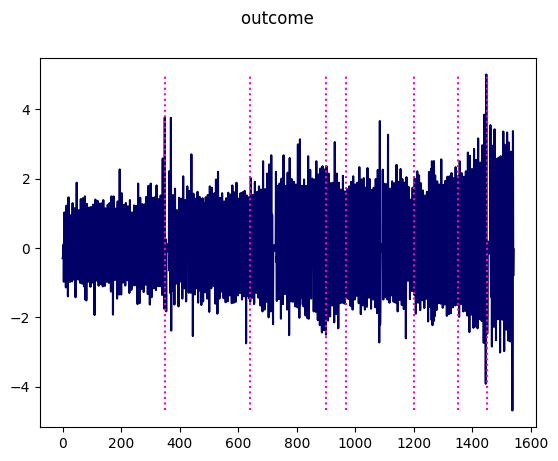

In [104]:
plot_data_with_cp(data_changed, series_column, changepoints=change_points)

In [105]:
data_val = data_changed[series_column].values

max_stationary_point = 350
data_stationary = [data_val[:max_stationary_point]]

### KLIEP

In [134]:
verbose = False
min_diff = 10
WINDOW_SIZE = 60

# The list of hyperparameters
sigma_list = [0.01, 0.05, 0.1, 0.15]

print('Validation change points:', change_points)
    
    
for sigma in sigma_list:
    
    #----------------------------------------------------
    # Step 1: tuning the threshold on the stationary part
    #----------------------------------------------------
    
    S_stationary = np.empty(0)
    for ds in data_stationary:
        
        S, _ = compute_test_stat_kliep(ds, window_size=WINDOW_SIZE, sigma=sigma)
        S_stationary = np.append(S_stationary, S)
        
    # Set the threshold as the maximal value on the stationary part
    z = np.max(S_stationary)
    zs = np.linspace(z-10, z+2, 15)
    print(zs)
    #----------------------------------------------------
    # Step 2: detect changes on the validation part
    #----------------------------------------------------
    for z in zs:
        # Initialization of the test statistic
        train_kliep(data_val, sigma, z, min_diff, WINDOW_SIZE, change_points, verbose=False)

Validation change points: [ 210  350  640  900  970 1200 1300 1450]
[118.30410491 119.16124776 120.01839062 120.87553348 121.73267634
 122.58981919 123.44696205 124.30410491 125.16124776 126.01839062
 126.87553348 127.73267634 128.58981919 129.44696205 130.30410491]
KLIEP, threshold = 118.30410490777831 . sigma = 0.01 . Number of false alarms: 2 ; average delay: 80.875 ± 44.32109401853704
KLIEP, threshold = 119.16124776492117 . sigma = 0.01 . Number of false alarms: 2 ; average delay: 80.875 ± 44.32109401853704
KLIEP, threshold = 120.01839062206402 . sigma = 0.01 . Number of false alarms: 2 ; average delay: 81.5 ± 44.24081825644729
KLIEP, threshold = 120.87553347920688 . sigma = 0.01 . Number of false alarms: 1 ; average delay: 83.125 ± 50.07853207712862
KLIEP, threshold = 121.73267633634974 . sigma = 0.01 . Number of false alarms: 1 ; average delay: 83.375 ± 50.119700467979655
KLIEP, threshold = 122.5898191934926 . sigma = 0.01 . Number of false alarms: 1 ; average delay: 83.625 ± 50.

Detected change point: 309
Detected change point: 435
Detected change point: 556
False Alarm
Detected change point: 678
Detected change point: 799
False Alarm
Detected change point: 920
Detected change point: 1042
Detected change point: 1198
Detected change point: 1319
Detected change point: 1440
KLIEP, threshold = 53 . sigma = 0.05 . Number of false alarms: 2 ; average delay: 41.625 ± 36.32126615359107


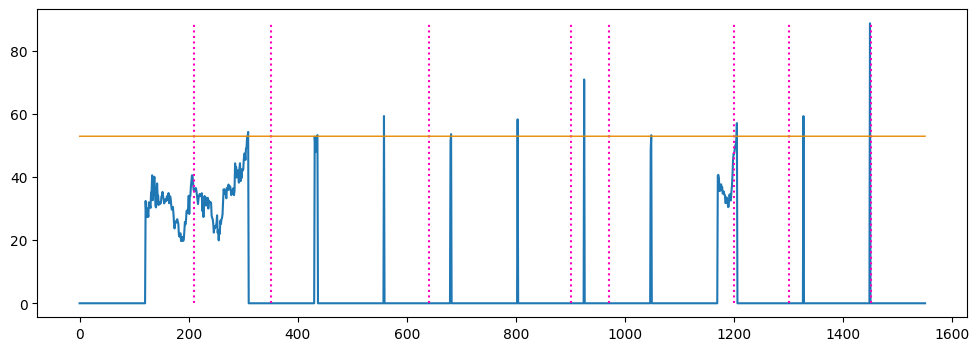

In [132]:
#TRAIN
sigma = 0.05
z = 53
min_diff = 10
WINDOW_SIZE=60
verbose=True


stat, delays = train_kliep(data_val, sigma, z, min_diff, WINDOW_SIZE, change_points, verbose=True)


plt.figure(figsize=(12, 4))
plt.plot(stat)
plt.vlines(x=change_points,  ymin=stat.min(), ymax=stat.max(), colors='#ff00bf', ls=':', lw=1.5)
plt.plot([z] * stat.shape[0], color="#e68a00", lw=1)
plt.show()

# Вывод

Подобрали гиперпараметры, видим, что работает супер круто, фолсы есть в точках с новым годом, который хотим не учитывать. Задержка при этом довольно мальнькая.